In [71]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import zipfile
import os
import tarfile
import random

from collections import defaultdict
from scipy import ndimage
from tensorflow.keras import regularizers
from urllib.request import urlretrieve
from scipy.io import loadmat

from tensorflow.keras import Model, Input, Sequential, initializers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Layer, InputSpec, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Add, Flatten, Activation
from tensorflow.keras.regularizers import L1L2

tf.keras.backend.set_floatx('float64')
dir_name = "aclImdb/"
special_tokens = ["<UNK>", "<PAD>"]

# Download data

In [ ]:
def download_file(url, path):
    print("Downloading from %s" % url)
    zip_path = path + ".zip"
    urlretrieve(url, zip_path)
    tar = tarfile.open(zip_path, "r:gz")
    tar.extractall()
    tar.close()
    os.remove(zip_path)    

In [ ]:
download_file("https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", "imdb")

# Read data

In [3]:
idx2word = special_tokens
word2idx = defaultdict(lambda: 0)
word2idx["<UNK>"] = 0
word2idx["<PAD>"] = 1
with open(dir_name + "imdb.vocab", encoding="utf-8") as f:
    for word in f:
        word = word.strip()
        idx2word.append(word)
        word2idx[word] = len(idx2word) - 2
        
print("Vocab length: %d" % len(idx2word))

def read_review_data(folder):
    raw_review_data = []
    for filename in os.listdir(dir_name + folder + "/neg"):
        with open(dir_name + folder + "/neg/" + filename, encoding="utf-8") as f:
            raw_review_data.append((f.read(), 0))

    for filename in os.listdir(dir_name + folder + "/pos"):
        with open(dir_name + folder + "/pos/" + filename, encoding="utf-8") as f:
            raw_review_data.append((f.read(), 1))
    
    random.shuffle(raw_review_data)
    return raw_review_data

raw_train_data = read_review_data("train")
raw_test_data = read_review_data("test")
        
train_len = len(raw_train_data)
val_len = int(train_len * 0.05)
raw_val_data = raw_train_data[:val_len]
raw_train_data = raw_train_data[val_len:]

print("Train size: %d. Val size: %d. Test size: %d." % (len(raw_train_data), len(raw_val_data), len(raw_test_data)))

Vocab length: 89529
Train size: 23750. Val size: 1250. Test size: 25000.


# Convert texts into arrays of indexes

## 1. Tokenize

In [7]:
from nltk.tokenize import sent_tokenize, word_tokenize
from bpemb import BPEmb

bpemb_en = BPEmb(lang="en", vs=200000)

def tokenize_bpe(text):
    return [t.replace("▁", "") for t in bpemb_en.encode(text)]

def tokenize(text):
    return [t.lower() for t in word_tokenize(text)]

## 2. Preprocess

In [8]:
import re
cleanr = re.compile('<.*?>')

def preprocess(text):
    cleantext = re.sub(cleanr, '', text)
    return cleantext

##  3. Remove stop words

In [10]:
from nltk.corpus import stopwords

english_stopwords = set(stopwords.words('english'))

def remove_stop_words(tokens):
    return [t for t in tokens if any(c.isalpha() for c in t) and t not in english_stopwords]

## 4. Putting all together

In [23]:
def text2tokens(text):
    text = preprocess(text)
    tokens = tokenize_bpe(text)
    tokens = remove_stop_words(tokens)
    return tokens

train_data = [(text2tokens(t), label) for t, label in raw_train_data]
val_data = [(text2tokens(t), label) for t, label in raw_val_data]
test_data = [(text2tokens(t), label) for t, label in raw_test_data]

# Analyze data

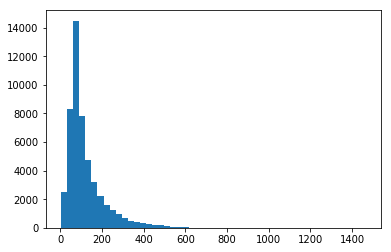

In [13]:
import matplotlib.pyplot as plt

lengths = [len(t[0]) for t in test_data] + [len(t[0]) for t in val_data] + [len(t[0]) for t in train_data]
plt.hist(lengths, bins = 50)
plt.show() # Max length ~ 600

# Pad data

In [27]:
max_length = 600

def pad_data(tokens, max_length):
    idxs = [word2idx[word] for word in tokens]
    pad_idx = word2idx["<PAD>"]
    if len(idxs) < max_length:
        idxs.extend([pad_idx] * (max_length - len(idxs)))
    else:
        return np.array(idxs[:max_length])
    return np.array(idxs)

def unzip(data):
    return np.array([t[0] for t in data]), np.array([t[1] for t in data])

x_train, y_train = unzip([(pad_data(t, max_length), label) for t, label in train_data])
x_val, y_val = unzip([(pad_data(t, max_length), label) for t, label in val_data])
x_test, y_test = unzip([(pad_data(t, max_length), label) for t, label in test_data])

In [17]:

n_words = len(idx2word)
embedding_dim = 50
batch_size = 32

model = Sequential([
    Embedding(input_dim=n_words, output_dim=embedding_dim, mask_zero=True),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          4476450   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               58880     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 4,543,651
Trainable params: 4,543,651
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=5, verbose=1)

Train on 23750 samples, validate on 1250 samples
Epoch 1/10
23750/23750 [==============================] - 420s 18ms/sample - loss: 0.3831 - accuracy: 0.8174 - val_loss: 0.3032 - val_accuracy: 0.8960
Epoch 2/10
23750/23750 [==============================] - 369s 16ms/sample - loss: 0.1779 - accuracy: 0.9354 - val_loss: 0.3198 - val_accuracy: 0.8912
Epoch 3/10
23750/23750 [==============================] - 367s 15ms/sample - loss: 0.0991 - accuracy: 0.9668 - val_loss: 0.3338 - val_accuracy: 0.8920
Epoch 4/10
  704/23750 [..............................] - ETA: 5:44 - loss: 0.0466 - accuracy: 0.9851

KeyboardInterrupt: 

In [19]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 126s 5ms/sample - loss: 0.5089 - accuracy: 0.8442


[0.5089302100123317, 0.84416]

# GloVe embeddings

## 1. Download embeddings

In [20]:
import urllib.request
import zipfile

url = 'http://nlp.stanford.edu/data/glove.twitter.27B.zip'
urllib.request.urlretrieve(url, 'twitter_glove')
with zipfile.ZipFile('twitter_glove', 'r') as zip_ref:
    zip_ref.extractall('twitter_glove_data')

## 2. Load embeddings

In [22]:
def load_glove_embeddings(embedding_dim, special_tokens):
    word2idx = defaultdict(lambda: 0)
    idx2word = special_tokens
    glove_weights = []
    for i, word in enumerate(idx2word):
        word2idx[word] = i
        glove_weights.append(np.zeros(embedding_dim))

    with open("twitter_glove_data/glove.twitter.27B.%dd.txt" % embedding_dim, "r", encoding="utf-8") as f:
        for line in f:
            word, *vector = line.split(' ')
            vector = np.array([float(v) for v in vector])
            word2idx[word] = len(idx2word)
            idx2word.append(word)
            glove_weights.append(vector)
    glove_weights = np.array(glove_weights)
    return word2idx, idx2word, glove_weights

word2idx, idx2word, glove_weights = load_glove_embeddings(100, special_tokens)

In [28]:
x_train, y_train = unzip([(pad_data(t, max_length), label) for t, label in train_data])
x_val, y_val = unzip([(pad_data(t, max_length), label) for t, label in val_data])
x_test, y_test = unzip([(pad_data(t, max_length), label) for t, label in test_data])

In [36]:
n_words = len(idx2word)
embedding_dim = 100
batch_size = 32
max_len = 600

model = Sequential([
    Embedding(input_dim=n_words, output_dim=embedding_dim, weights=[glove_weights], trainable=False, input_length=max_len, mask_zero=True),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 100)          119351600 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [37]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=5, verbose=1)

Train on 23750 samples, validate on 1250 samples
Epoch 1/5
23750/23750 [==============================] - 423s 18ms/sample - loss: 0.4563 - accuracy: 0.7741 - val_loss: 0.3833 - val_accuracy: 0.8136
Epoch 2/5
23750/23750 [==============================] - 403s 17ms/sample - loss: 0.3723 - accuracy: 0.8274 - val_loss: 0.3186 - val_accuracy: 0.8672
Epoch 3/5
23750/23750 [==============================] - 408s 17ms/sample - loss: 0.3392 - accuracy: 0.8479 - val_loss: 0.4118 - val_accuracy: 0.8472
Epoch 4/5
 3328/23750 [===>..........................] - ETA: 5:48 - loss: 0.3542 - accuracy: 0.8428

KeyboardInterrupt: 

## Enhance model

In [ ]:
n_words = len(idx2word)
embedding_dim = 100
batch_size = 32
max_len = 600

model = Sequential([
    Embedding(input_dim=n_words, output_dim=embedding_dim, weights=[glove_weights], trainable=False, input_length=max_len, mask_zero=True),
    Bidirectional(LSTM(128)),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=5, verbose=1)

## Existing model

In [39]:
import zipfile

#urlretrieve("https://github.com/bfelbo/DeepMoji/archive/master.zip", "master.zip")
with zipfile.ZipFile("master.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
    
import sys
sys.path.insert(0, "DeepMoji-master")

urlretrieve("https://uc5e9e71e056a7db22fe03924e9c.dl.dropboxusercontent.com/cd/0/get/A1kiXKCzvHsOx7AasrgtoVozK8wpXlIbyQkFCplavFNREAZ-kYxGkiVctR02z9uld00rTMQFwL4nl26dUdlYGtzOOh42VDS_V0uEMDae9cvKkw/file?_download_id=65003392492753452134180909853568979055614964122693868972846519&_notify_domain=www.dropbox.com&dl=1", "deepmoji_weights.hdf5")

In [128]:
from deepmoji.model_def import deepmoji_architecture
from deepmoji.model_def import deepmoji_emojis, deepmoji_feature_encoding
import keras

deepmoji_base = deepmoji_feature_encoding(600, "deepmoji_weights.hdf5")
for layer in deepmoji_base.layers:
    layer.trainable = False

x = deepmoji_base.output
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
preds = keras.layers.Dense(1)(x)

deepmoji_model=keras.Model(deepmoji_base.input, outputs=preds)

deepmoji_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
deepmoji_model.summary()
for layer in deepmoji_model.layers:
    print(layer.trainable)

Loading weights for embedding
Loading weights for bi_lstm_0
Loading weights for bi_lstm_1
Loading weights for attlayer
Ignoring weights for softmax
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 600)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 600, 256)     12800000    input_23[0][0]                   
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 600, 256)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 600,

In [94]:
import json

VOCAB_PATH = "DeepMoji-master/model/vocabulary.json"
print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
with open(VOCAB_PATH, 'r') as f:
    word2idx = json.load(f)
    
idx2word = [None] * len(word2idx)
for word, idx in word2idx.items():
    idx2word[idx] = word

Tokenizing using dictionary from DeepMoji-master/model/vocabulary.json


In [124]:
def text2idxs_deep_emoji(text, max_len=600):
    text = preprocess(text)
    tokens = tokenize(text)
    tokens = [t for t in tokens if t not in english_stopwords]
    idxs = []
    for token in tokens:
        if token not in word2idx:
            idxs.append(word2idx["CUSTOM_UNKNOWN"])
        else:
            idxs.append(word2idx[token])
    pad_idx = word2idx["CUSTOM_MASK"]
    if len(idxs) < max_len:
        idxs.extend([pad_idx] * (max_len - len(idxs)))
    else:
        return np.array(idxs[:max_length])
    return np.array(idxs)

train_data = [(text2idxs_deep_emoji(t), label) for t, label in raw_train_data]
val_data = [(text2idxs_deep_emoji(t), label) for t, label in raw_val_data]
test_data = [(text2idxs_deep_emoji(t), label) for t, label in raw_test_data]

x_train, y_train = unzip(train_data)
x_val, y_val = unzip(val_data)
x_test, y_test = unzip(test_data)

In [137]:
from deepmoji.model_def import deepmoji_transfer
from deepmoji.finetuning import (
    load_benchmark,
    finetune)


nb_classes = 2
max_len = 600

deepmoji_model = deepmoji_transfer(nb_classes, max_len, "deepmoji_weights.hdf5")
deepmoji_model.summary()

model, acc = finetune(deepmoji_model, [x_train, x_val, x_test], [y_train, y_val, y_test], nb_classes,
                      64, method='chain-thaw')
print('Acc: {}'.format(acc))

Loading weights for embedding
Loading weights for bi_lstm_0
Loading weights for bi_lstm_1
Loading weights for attlayer
Ignoring weights for softmax
Model: "DeepMoji"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 600)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 600, 256)     12800000    input_24[0][0]                   
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 600, 256)     0           embedding[0][0]                  
__________________________________________________________________________________________________
embed_drop (SpatialDropout1D)   (None, 600

KeyboardInterrupt: 

In [129]:
history = deepmoji_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=5, verbose=1)

Train on 23750 samples, validate on 1250 samples
Epoch 1/5
23750/23750 [==============================] - 1402s 59ms/step - loss: 0.4164 - accuracy: 0.1818 - val_loss: 0.3759 - val_accuracy: 0.1664
Epoch 2/5
  288/23750 [..............................] - ETA: 22:10 - loss: 0.4091 - accuracy: 0.1944

KeyboardInterrupt: 